#Double 7's (Short Term Trading Strategies that Work)

In [1]:
%matplotlib inline

Use future imports for python 3.0 forward compatibility

In [2]:
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

Other imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

# Double the DPI, so we are making 2x plots:
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

Some global data

In [4]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
#symbol = 'GDX'
capital = 10000
start = datetime.datetime(1900, 1, 1)
#end = datetime.datetime(1970, 12, 1)
end = datetime.datetime.now()

Fetch symbol data from internet

In [5]:
ts = pf.fetch_timeseries(symbol)

In [6]:
ts.head()

,open,high,low,close,volume,adj_close
date,,,,,,
1993-01-29,43.97,43.97,43.75,43.94,1003200,28.92
1993-02-01,43.97,44.25,43.97,44.25,480500,29.13
1993-02-02,44.22,44.38,44.12,44.34,201300,29.19
1993-02-03,44.41,44.84,44.38,44.81,529400,29.50
1993-02-04,44.97,45.09,44.47,45.00,531500,29.62


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [7]:
ts = pf.select_tradeperiod(ts, start, end, use_adj=False)

In [8]:
ts.head()

,open,high,low,close,volume,adj_close
date,,,,,,
1993-01-29,43.97,43.97,43.75,43.94,1003200,28.92
1993-02-01,43.97,44.25,43.97,44.25,480500,29.13
1993-02-02,44.22,44.38,44.12,44.34,201300,29.19
1993-02-03,44.41,44.84,44.38,44.81,529400,29.50
1993-02-04,44.97,45.09,44.47,45.00,531500,29.62


Add technical indicator: 200 day ma

In [9]:
sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

In [10]:
ts.tail()




,open,high,low,close,volume,adj_close,sma200
date,,,,,,,
2015-07-06,205.77,207.65,205.53,206.67,113786000,206.67,205.55
2015-07-07,206.96,208.17,204.11,208.01,170938200,208.01,205.58
2015-07-08,208.02,208.02,204.25,204.53,159250700,204.53,205.60
2015-07-09,207.04,207.35,204.77,204.80,139210600,204.80,205.63
2015-07-10,207.29,207.98,204.95,207.48,126039800,207.48,205.67


Add technical indicator: 7 day high, and 7 day low

In [11]:
period_high = pd.rolling_max(ts.close, 7)
period_low = pd.rolling_min(ts.close, 7)
ts['period_high'] = period_high
ts['period_low'] = period_low

In [12]:
ts.tail()

,open,high,low,close,volume,adj_close,sma200,period_high,period_low
date,,,,,,,,,
2015-07-06,205.77,207.65,205.53,206.67,113786000,206.67,205.55,209.90,205.47
2015-07-07,206.96,208.17,204.11,208.01,170938200,208.01,205.58,209.90,205.47
2015-07-08,208.02,208.02,204.25,204.53,159250700,204.53,205.60,208.01,204.53
2015-07-09,207.04,207.35,204.77,204.80,139210600,204.80,205.63,208.01,204.53
2015-07-10,207.29,207.98,204.95,207.48,126039800,207.48,205.67,208.01,204.53


Plot closing price along with moving averages

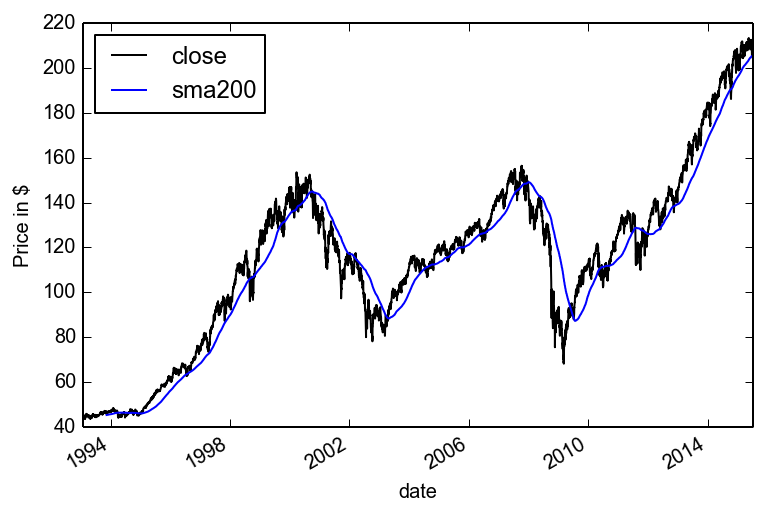

In [13]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [14]:
tlog = pf.TradeLog()
dbal = pf.DailyBal()

Algo:
1. The SPY is above its 200-day moving average
2. The SPY closes at a 7-day low, buy.
3. If the SPY closes at a 7-day high, sell your long position.

In [15]:
cash = capital
shares = 0
start_flag = True
stop_loss = 0

import time
t0 = time.time()


for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma200 = ts['sma200'][i]
    period_high = ts['period_high'][i]
    period_low = ts['period_low'][i]

    if pd.isnull(sma200) or ts.index[i] < start:
        continue
    elif start_flag:
        start_flag = False
        # set start and end
        start = ts.index[i]
        end = ts.index[-1]

    # buy
    if tlog.num_open_trades() == 0:
        if close > sma200 and close == period_low:

            # calculate shares to buy and remaining cash
            shares, cash = tlog.calc_shares(cash, close)

            # enter buy in trade log
            tlog.enter_trade(date, close, shares)
            print("{0} BUY  {1} {2} @ {3:.2f}".format(date, shares, symbol, close))

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.OPEN)
            
            # set stop loss
            stop_loss = 0*close
        else:
            # hold
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)

    # sell
    elif (close == period_high) or \
         (low < stop_loss) or \
         (i == len(ts.index) - 1):

            # enter sell in trade log
            idx = tlog.exit_trade(date, close)
            shares = tlog.get_log()['qty'][idx]
            print("{0} SELL {1} {2} @ {3:.2f}".format(date, shares, symbol, close))
            if (close < stop_loss):
                print("--------------------STOP-----------------------------")

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.CLOSE)   
            
            # update cash
            cash = tlog.calc_cash(cash, close, shares)
            
            # update shares
            shares = 0

    # hold
    else:
        dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)    

t1 = time.time()
total = t1-t0
print(total)
        

1993-11-19 00:00:00 BUY  215 SPY @ 46.31
1993-12-02 00:00:00 SELL 215.0 SPY @ 46.53
1993-12-14 00:00:00 BUY  215 SPY @ 46.53
1993-12-22 00:00:00 SELL 215.0 SPY @ 46.78
1993-12-31 00:00:00 BUY  216 SPY @ 46.59
1994-01-07 00:00:00 SELL 216.0 SPY @ 47.03
1994-01-24 00:00:00 BUY  216 SPY @ 47.19
1994-01-27 00:00:00 SELL 216.0 SPY @ 47.75
1994-02-04 00:00:00 BUY  219 SPY @ 46.97
1994-02-15 00:00:00 SELL 219.0 SPY @ 47.47
1994-02-18 00:00:00 BUY  222 SPY @ 46.88
1994-03-07 00:00:00 SELL 222.0 SPY @ 46.94
1994-03-21 00:00:00 BUY  222 SPY @ 46.84
1994-04-21 00:00:00 SELL 222.0 SPY @ 44.91
1994-09-07 00:00:00 BUY  211 SPY @ 47.27
1994-09-15 00:00:00 SELL 211.0 SPY @ 47.64
1994-10-21 00:00:00 BUY  216 SPY @ 46.56
1994-10-28 00:00:00 SELL 216.0 SPY @ 47.66
1994-11-04 00:00:00 BUY  222 SPY @ 46.33
1994-12-14 00:00:00 SELL 222.0 SPY @ 45.75
1995-03-07 00:00:00 BUY  210 SPY @ 48.44
1995-03-10 00:00:00 SELL 210.0 SPY @ 49.27
1995-04-18 00:00:00 BUY  204 SPY @ 50.61
1995-04-24 00:00:00 SELL 204.0 SPY 

Retrieve log DataFrames

In [16]:
tlog = tlog.get_log()

In [17]:
tlog.tail(100)

,entry_date,entry_price,long_short,qty,exit_date,exit_price,pl_points,pl_cash,cumul_total
114,2005-09-14,123.21,long,238.00,2005-09-29 00:00:00,122.66,-0.55,-130.90,19268.34
115,2005-10-04,121.22,long,241.00,2005-10-19 00:00:00,119.78,-1.44,-347.04,18921.30
116,2005-11-30,125.41,long,230.00,2005-12-13 00:00:00,127.31,1.90,437.00,19358.30
117,2005-12-19,125.71,long,233.00,2006-01-04 00:00:00,127.30,1.59,370.47,19728.77
118,2006-01-17,128.33,long,231.00,2006-01-27 00:00:00,128.54,0.21,48.51,19777.27
119,2006-02-03,126.27,long,235.00,2006-02-14 00:00:00,127.75,1.48,347.80,20125.07
120,2006-02-28,128.23,long,234.00,2006-03-13 00:00:00,128.83,0.60,140.40,20265.48
121,2006-03-28,129.22,long,234.00,2006-04-04 00:00:00,130.56,1.34,313.56,20579.04
122,2006-04-07,129.54,long,236.00,2006-04-18 00:00:00,130.70,1.16,273.76,20852.80
123,2006-05-12,129.24,long,238.00,2006-05-25 00:00:00,127.73,-1.51,-359.38,20493.42


In [18]:
dbal = dbal.get_log()

In [19]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2015-07-06,53410.64,52865.81,53158.78,257.00,44.60,1
2015-07-07,53544.28,52500.87,53503.16,257.00,44.60,1
2015-07-08,53505.74,52536.85,52608.81,257.00,44.60,1
2015-07-09,53333.55,52670.49,52678.20,257.00,44.60,1
2015-07-10,53495.45,52716.74,53366.95,257.00,44.60,2


Generate strategy stats - display all available stats

In [20]:
stats = pf.stats(ts, tlog, dbal, start, end, capital)
pf.print_full(stats)

start                                                   1993-11-11
end                                                     2015-07-10
beginning_balance                                            10000
ending_balance                                            53366.95
total_net_profit                                          43366.95
gross_profit                                              70521.79
gross_loss                                               -27154.84
profit_factor                                                 2.60
return_on_initial_capital                                   433.67
annual_return_rate                                            8.04
trading_period                           21 years 7 months 29 days
pct_time_in_market                                           33.52
total_num_trades                                               214
num_winning_trades                                             168
num_losing_trades                                             

Run Benchmark

In [21]:
benchmark = pf.Benchmark(symbol, capital, start, end)
benchmark.run()

1993-11-11 00:00:00 BUY  321 SPY @ 31.08
2015-07-10 00:00:00 SELL 321.0 SPY @ 207.48


Retrieve benchmark logs

In [22]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [23]:
benchmark.stats = benchmark.stats()
pf.print_full(benchmark.stats)

start                                                   1993-11-11
end                                                     2015-07-10
beginning_balance                                            10000
ending_balance                                            66624.28
total_net_profit                                          56624.28
gross_profit                                              56624.28
gross_loss                                                    0.00
profit_factor                                                 1000
return_on_initial_capital                                   566.24
annual_return_rate                                            9.15
trading_period                           21 years 7 months 29 days
pct_time_in_market                                          100.00
total_num_trades                                                 1
num_winning_trades                                               1
num_losing_trades                                             

Plot Equity Curves: Strategy vs Benchmark

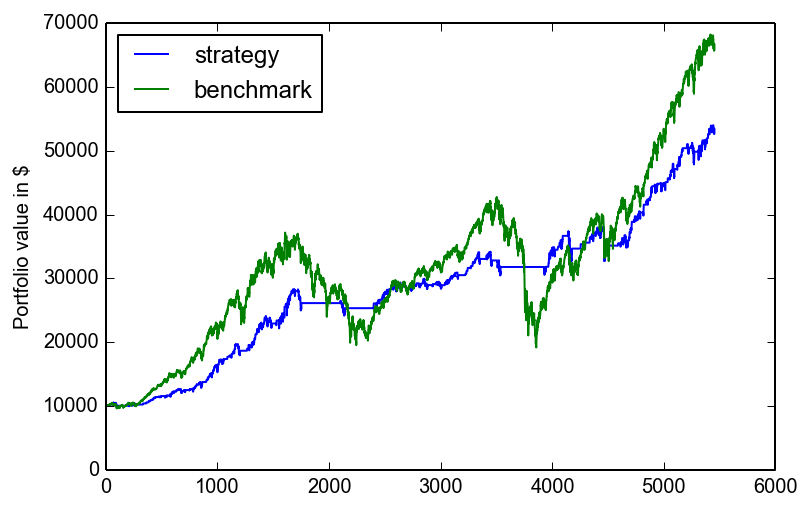

In [24]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

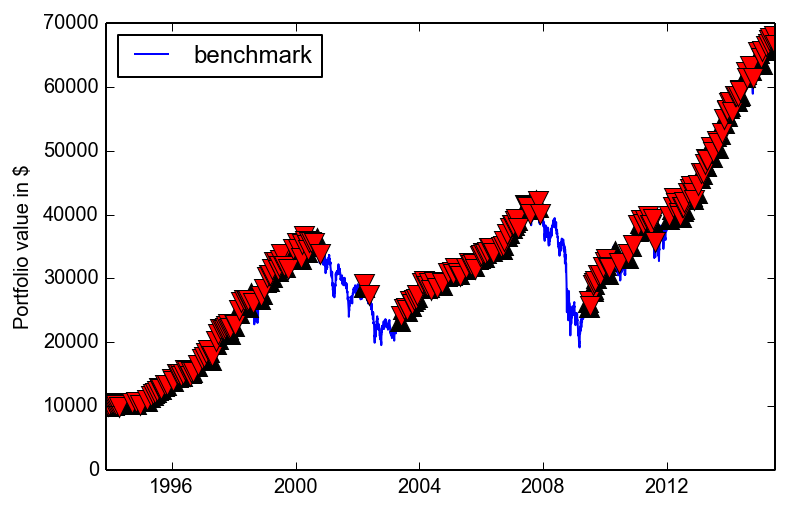

In [25]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,8.04,9.15
max_closed_out_drawdown,-14.63,-55.16
drawdown_annualized_return,-1.82,-6.03
drawdown_recovery,-1.84,-1.42
best_month,12.88,23.59
worst_month,-13.54,-29.39
sharpe_ratio,0.83,0.55
sortino_ratio,0.63,0.73
monthly_std,2.10,4.50


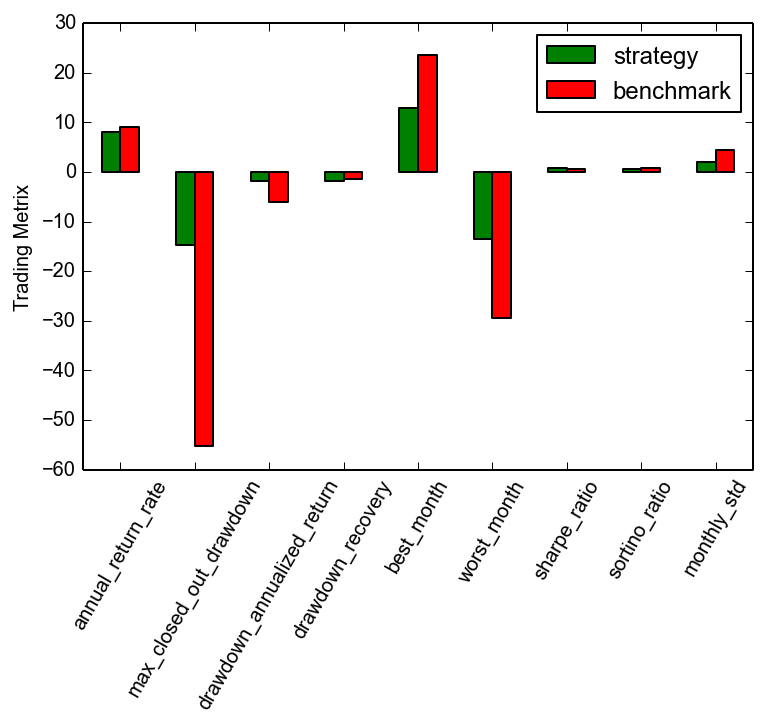

In [26]:

metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df